In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import sys
from analysis_utils import *

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
from pandas import DataFrame, Series

from toolz.curried import get, curry

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define Environment

In [13]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_env(mu=0, sigma=6, quantization=4, cost=1.00, seed=None, branching=[3,1,2], **kwargs):
    if seed is not None:
        np.random.seed(seed)

    def reward(depth):
        if depth > 0:
            return Categorical([-10, -5, 5, 10])
#             d = Normal(mu, sigma).to_discrete(quantization)
#             return Categorical(map(round, d.vals), d.probs)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

env = make_env()

# Load Data

In [18]:
from analysis_utils import *
VERSION = 'c1.1'
data = get_data(VERSION, '../experiment/data')
pdf = data['participants']
print(f'{len(pdf)} participants')
mdf = data['mouselab-mdp']

pdf = pdf.loc[pdf.completed].copy()
print(f'{len(pdf)} participants')
complete = list(pdf.index)

def extract(q):
    return list(map(int, q['click']['state']['target']))

mdf = data['mouselab-mdp'].query('pid == @complete').copy()
mdf['clicks'] = mdf.queries.apply(extract)
mdf['n_clicks'] = mdf.clicks.apply(len)
mdf['thinking'] = mdf['rt'].apply(get(0, default=0))

tdf = mdf.query('block == "test"').copy()
tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

# pdf['total_time'] = exp_data['survey'].time_elapsed / 60000

pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.mean()
pdf['thinking'] = mdf.groupby('pid').thinking.mean()

def get_env(state_rewards):
    state_rewards[0] = 0
    return make_env(ground_truth=state_rewards)

tdf['env'] = tdf.state_rewards.apply(get_env)

import json
def excluded_pids():
    sdf = data['survey-multi-choice'].query('pid == @complete').copy()
    sdf = pd.DataFrame(list(sdf.responses), index=sdf.index)
    correct = pd.Series(['-$10 to $10', '$1', '1 cent for every $1 you make in the game'])
    fail_quiz = (sdf != correct).sum(axis=1) > 1
    no_click = mdf.query('block == "train_inspector"').groupby('pid').n_clicks.sum() == 0
    return fail_quiz | no_click

exclude = excluded_pids()
tdf['exclude'] = list(exclude.loc[tdf.pid])
tdf = tdf.query('~exclude').copy().drop('exclude', axis=1)
print(f'excluding {exclude.sum()} out of {len(exclude)} partipicants')

62 participants
60 participants
excluding 9 out of 60 partipicants


11.21  3.39  4.51


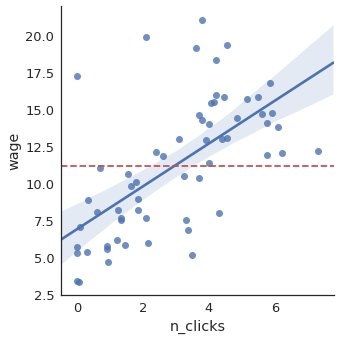

In [327]:
pdf['pay'] = (1 + pdf.bonus)
pdf['wage'] = pdf.pay / (pdf.total_time / 60)
print(f'{pdf.wage.mean():.2f}  {pdf.wage.min():.2f}  {pdf.wage.std():.2f}')

sns.lmplot('n_clicks', 'wage', data=pdf)
plt.axhline(pdf.wage.mean(), c='r', ls='--')

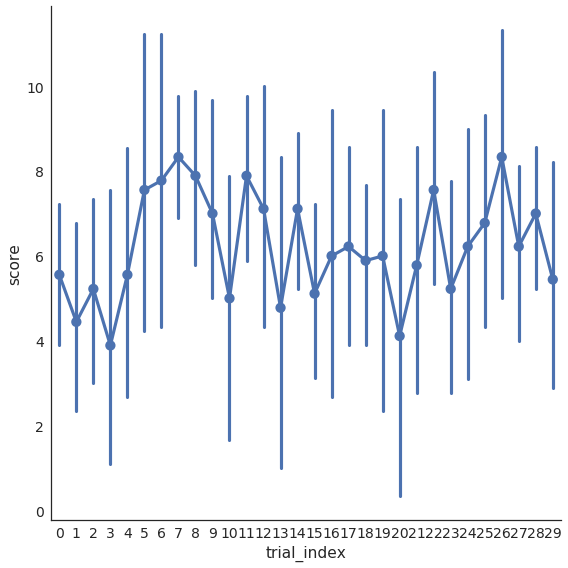

In [8]:
sns.factorplot('trial_index', 'score', data=tdf, size=8)

# Python stats

In [9]:
import statsmodels.formula.api as smf
model = smf.ols('score ~ trial_index', data=tdf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2673
Date:                Wed, 24 Jan 2018   Prob (F-statistic):              0.606
Time:                        13:40:49   Log-Likelihood:                -779.59
No. Observations:                 270   AIC:                             1563.
Df Residuals:                     268   BIC:                             1570.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.0036      0.518     11.601      0.000       4.985       7.022
trial_index     0.0158      0.031      0.517      0.606      -0.044       0.076
==============================================================================
Omnibus:                        1.085   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.581   Jarque-Bera (JB):                1.193
Skew:                          -0.126   Prob(JB):                        0.551
Kurtosis:                       2.794   Cond. No.                         33.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Test qualitative predictions

1. The first observed node is a stem node.
1. The second observed node is a leaf node.
1. Observe at least two pieces of information.
1. If the first observed node is a non-leaf and its revealed value is above average (5 or 10), then people should inspect a leaf node on the same branch. But if the value is below average (0 or -4) then they should inspect a leaf node on a different branch.
1. People should not stop after only two observations unless the non-leaf reward was below average and the leaf reward on the other branch was large (+10).
1. People should never stop collecting information until they have at least found a path with an above-average expected return (5 + mu_R) or have pruned all paths but one.
1. The aspiration level decreases as more information is observed. This means that the average expected return upon stopping should decrease with the number of observations.

### Prediction 1: The first observed node is a stem node rather than a leaf node.

In [32]:
from statsmodels.stats.proportion import binom_test
from scipy import stats

trial_ids = tdf['clicks'].keys()

first_click = np.array([])
second_click = np.array([])

first_observation = np.array([])

first_click_level = np.array([])
second_click_level = np.array([])

first_click_branch = np.array([])
second_click_branch = np.array([])

observed_value = np.array([])
second_observed_value = np.array([])

nr_levels = 3
nr_branches = 3

leaf_nodes = [3,4,7,8,11,12]
stem_nodes = [1,5,9]
branch_nodes = [2,6,10]


nodes_by_depth=[stem_nodes,branch_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3,4],[5,6,7,8],[9,10,11,12]]


nr_clicks = np.array([])

for t in trial_ids:
        
    clicks = tdf['clicks'][t]
    if len(clicks)>0:
        first_click = np.append(first_click,[clicks[0]])
        
        for level in range(nr_levels):
            if np.isin(first_click[-1],nodes_by_depth[level]):
                first_click_level = np.append(first_click_level,level+1)

        for branch in range(nr_branches):
            if np.isin(first_click[-1],nodes_by_branch[branch]):
                first_click_branch = np.append(first_click_branch,branch+1)
                
        #todo: push the observed value
        trial_id = tdf['trial_id'][t]
        rewards =tdf['env'][t].ground_truth
        
        first_obs = rewards[int(first_click[-1])]
        observed_value = np.append(observed_value,[first_obs])
        nr_clicks = np.append(nr_clicks,len(clicks))
        if len(clicks)>1:
            second_click = np.append(second_click,[clicks[1]])
            for level in range(nr_levels):
                if np.isin(second_click[-1],nodes_by_depth[level]):
                    second_click_level = np.append(second_click_level,level+1)
            
            for branch in range(nr_branches):
                if np.isin(second_click[-1],nodes_by_branch[branch]):
                    second_click_branch = np.append(second_click_branch,branch+1)
            
            second_obs = rewards[int(second_click[-1])]
            second_observed_value= np.append(second_observed_value,[second_obs])

        else:
            second_click = np.append(second_click,[17])
            second_click_level = np.append(second_click_level,[0])
            second_click_branch = np.append(second_click_branch,[0])
            second_observed_value = np.append(second_observed_value,[None])


print("{:4.1f}% of the first clicks were on stem nodes.".format(100*np.mean(first_click_level==1)))
print("{:4.1f}% of the first clicks were on branch nodes.".format(100*np.mean(first_click_level==2)))
print("{:4.1f}% of the first clicks were on leaf nodes.".format(100*np.mean(first_click_level==3)))

#int(np.sum(first_click_level==1))
#p_less_leafs = binom_test(int(np.sum(first_click_level==3)),int(len(first_click_level)),0.5,'smaller')

chi2_results=stats.chi2_contingency([[len(first_click_level),np.sum(first_click_level==3)],[len(first_click_level),np.sum(first_click_level<3)]])

chi2_branch_vs_stem=stats.chi2_contingency([[len(first_click_level),np.sum(first_click_level==1)],[len(first_click_level),np.sum(first_click_level==2)]])


print("Like the optimal strategy, people's first click is more often a stem or branch node than a leaf node (p={}).".format(chi2_results[1]))

#p_less_than_one = binom_test(int(np.sum(first_click_level==1)),int(len(first_click_level)),1,'smaller')

print(chi2_branch_vs_stem[1])


72.6% of the first clicks were on stem nodes.
10.0% of the first clicks were on branch nodes.
17.4% of the first clicks were on leaf nodes.
Like the optimal strategy, people's first click is more often a stem or branch node than a leaf node (p=2.3071635152225327e-87).
1.97269732649e-103


### Prediction 2: Participants make at least two clicks on every trial.

In [22]:
print("Participants collect at least two pieces of information on {:4.1f}% of the trials.".format(100*np.mean(nr_clicks>=2)))

p_nr_clicks = binom_test(int(np.sum(nr_clicks>=2)),int(len(nr_clicks)),0.5)

print("This is significantly more often than would be expected by chance (p={}).".format(p_nr_clicks))

for n in range(13):
    print("Participants collect at least {} pieces of information on {:4.1f}% of the trials.".format(n+1,100*np.mean(nr_clicks>n)))

Participants collect at least two pieces of information on 89.1% of the trials.
This is significantly more often than would be expected by chance (p=2.218190309032456e-202).
Participants collect at least 1 pieces of information on 100.0% of the trials.
Participants collect at least 2 pieces of information on 89.1% of the trials.
Participants collect at least 3 pieces of information on 77.7% of the trials.
Participants collect at least 4 pieces of information on 59.2% of the trials.
Participants collect at least 5 pieces of information on 44.7% of the trials.
Participants collect at least 6 pieces of information on 32.1% of the trials.
Participants collect at least 7 pieces of information on 20.8% of the trials.
Participants collect at least 8 pieces of information on 15.0% of the trials.
Participants collect at least 9 pieces of information on  9.9% of the trials.
Participants collect at least 10 pieces of information on  5.7% of the trials.
Participants collect at least 11 pieces of i

### Prediction 3: If the first observed values is better than average, people should stay on the same branch, and else they should switch to a different branch. 
.

In [23]:
same_branch = first_click_branch[nr_clicks>1] == second_click_branch[nr_clicks>1]
branch_switch = first_click_branch[nr_clicks>1] != second_click_branch[nr_clicks>1]

smallest_good_value = 5
best_value = 10
best_bad_value = 0
leaf_level = 3

good_observation = observed_value[nr_clicks>1] >= smallest_good_value
bad_observation = observed_value[nr_clicks>1] <= best_bad_value

stopped_after_good_obs = second_click_level[np.logical_and(observed_value>= smallest_good_value , first_click_level < leaf_level)]==0
stopped_after_good_observation = 100 * np.mean(stopped_after_good_obs)
p_stopped = binom_test(int(np.sum(stopped_after_good_obs)),int(len(stopped_after_good_obs)),0.5)

continued_after_bad_obs = second_click_level[np.logical_and(observed_value<= best_bad_value , first_click_level < leaf_level)]!=0
continued_after_bad_observation = 100 * np.mean(continued_after_bad_obs)
p_continued = binom_test(int(np.sum(continued_after_bad_obs)),int(len(continued_after_bad_obs)),0.5)


#print("If the observed value was bad then {:3.1f}% continued planning (p={}).".format(continued_after_bad_observation,p_continued))
#print("If the observed value was good then {:3.1f}% stopped planning (p={}).".format(stopped_after_good_observation,p_stopped))

switch_away_from_bad = branch_switch[bad_observation]
p_switched_from_bad = binom_test(int(np.sum(switch_away_from_bad)),int(len(switch_away_from_bad)),0.5)

switch_away_from_good = branch_switch[good_observation]
p_switched_from_good = binom_test(int(np.sum(switch_away_from_good)),int(len(switch_away_from_good)),0.5)

print("If the observed value was below average then {:3.1f}% switched the branch (p={}).".format(100*np.mean(switch_away_from_bad),p_switched_from_bad))
print("If the observed value was above average then {:3.1f}% stayed on the branch (p={}).".format(100-100*np.mean(switch_away_from_good),p_switched_from_good))


If the observed value was below average then 86.4% switched the branch (p=2.4070624030990646e-85).
If the observed value was above average then 59.7% stayed on the branch (p=1.0016524616603243e-05).


### Prediction 4: If the first observed node is a non-leaf and its revealed value is positive but small (+5), then people should inspect another non-leaf on the same branch, and if its revealed value is large and positive (+10), then people should inspect a leaf on the same branch. 

In [24]:
best_value = 10
smallest_good_value = 5

small_good_observation =  observed_value[nr_clicks>1] == smallest_good_value
large_good_observation =  observed_value[nr_clicks>1] == best_value

second_click_on_leaf = second_click_level[nr_clicks>1] == 3

leaf_same_branch = np.logical_and(second_click_on_leaf,same_branch)
nonleaf_same_branch = np.logical_and(second_click_on_leaf==False,same_branch)
leaf_different_branch = np.logical_and(second_click_on_leaf,branch_switch)
nonleaf_different_branch = np.logical_and(second_click_on_leaf==False,branch_switch)

print("If the first observation was a large positive value, then {:3.1f}% of the following clicks were leafs on the same branch.".format(100*np.mean(leaf_same_branch[large_good_observation])))
print("If the first observation was a large positive value, then {:3.1f}% of the following clicks were nonleafs on the same branch.".format(100*np.mean(nonleaf_same_branch[large_good_observation])))
print("If the first observation was a small good value, then {:3.1f}% of the following clicks were nonleafs on the same branch.".format(100*np.mean(nonleaf_same_branch[small_good_observation])))
print("Following a small good value people would switch the branch {:3.1f}% of the time.".format(100*np.mean(branch_switch[small_good_observation])))
print("Following a small good value people would inspect a leaf on the same branch {:3.1f}% of the time.".format(100*np.mean(leaf_same_branch[small_good_observation])))

#print(np.mean(nonleaf_different_branch[small_good_observation]))
#print(np.mean(nonleaf_different_branch[small_good_observation]))

#percent_leafs_after_large_good_obs = 100 * np.mean(second_click_level[np.logical_and(observed_value>= smallest_good_value , first_click_level < leaf_level)]==leaf_level)
#percent_leafs_after_bad_obs = 100 * np.mean(second_click_level[np.logical_and(observed_value<= best_bad_value , first_click_level < leaf_level)]==leaf_level)

#print("\nFrequency of agreement with the model: ")
#print("{:3.1f}% of the clicks following a good observation were leafs on the same branch.".format(100*np.mean(leaf_on_same_branch[good_observation])))
#print("{:3.1f}% of the clicks following a bad observation were leafs on the other branch.".format(100*np.mean(leaf_on_different_branch[bad_observation])))
#print("{:3.1f}% of the clicks following a bad observation were the stem of the other branch.".format(100*np.mean(nonleaf_on_different_branch[bad_observation])))

#print("\nFrequency of disagreement with the model: ")
#print("Following a bad observation participants inspected the stem of the other branch {:3.1f}% of the time.".format(100*np.mean(nonleaf_on_different_branch[bad_observation])))
#print("Following a bad observation participants inspected a leaf on the same branch {:3.1f}% of the time.".format(100*np.mean(leaf_on_same_branch[bad_observation])))
#print(np.mean(leafs_on_same_branch[bad_observation]))
#print(np.mean(nonleaf_on_different_branch[good_observation]))


#percent_leafs_after_bad_obs = 100 * np.mean(second_click_level[np.logical_and(observed_value<= best_bad_value , first_click_level < leaf_level)]==leaf_level)


#print("\nIf the observed value was above average, then {:3.1f}% clicked on a leaf afterward.".format(percent_leafs_after_good_obs))
#print("If the observed value was below average, then {:3.1f}% clicked on a leaf afterward".format(percent_leafs_after_bad_obs))

If the first observation was a large positive value, then 28.9% of the following clicks were leafs on the same branch.
If the first observation was a large positive value, then 51.5% of the following clicks were nonleafs on the same branch.
If the first observation was a small good value, then 25.1% of the following clicks were nonleafs on the same branch.
Following a small good value people would switch the branch 57.0% of the time.
Following a small good value people would inspect a leaf on the same branch 17.9% of the time.


### Prediction 5: People should always inspect a node that lies on a path with maximal expected return.

In [25]:
#Compute the expected termination rewards
COST=1
trial_ids = tdf['clicks'].keys()

term_rewards = np.array([])
nr_clicks = np.array([])
nr_unobserved_optimal_paths = np.array([])

click_on_a_best_path = np.array([])   
click_nr =np.array([])
click_level = np.array([])
deltas = np.array([])
optimal_path_has_unobserved_leafs = np.array([])
optimal_path_has_unobserved_stem = np.array([])
only_one_path = np.array([])

for t in trial_ids:

    trial_id = tdf['trial_id'][t]
    ground_truth = tdf['env'][t].ground_truth
    env = tdf['env'][t]
    clicks = tdf['clicks'][t]
    
    paths = env.all_paths()
    
    #print(ER_by_path)
        
    env.reset()
    c=0
    for click in clicks:
        c+=1
        click_nr = np.append(click_nr,[c])
        
        path_observable = np.array([])
        for p in range(len(paths)):
            path_observable = np.append(path_observable,[np.any([hasattr(env._state[x], 'sample') for x in paths[p][1:]])])
        
        observable_path_idx = np.where(path_observable == 1)[0]                              
        ER_by_path = [env.node_quality(paths[idx][-1]).expectation() for idx in observable_path_idx]
        
        max_ER = np.amax(ER_by_path)
        
        if len(ER_by_path)>=2:
            sort_args = np.argsort(ER_by_path)
            second_best_ER = ER_by_path[sort_args[-2]]        
            deltas = np.append(deltas, [max_ER - second_best_ER])
            only_one_path = np.append(only_one_path,[False])
        else:
            deltas = np.append(deltas, [max_ER])
            only_one_path = np.append(only_one_path,[True])
                
        for level in range(nr_levels):
            if np.isin(click,nodes_by_depth[level]):
                click_level = np.append(click_level,level+1)
        
        best_idx = observable_path_idx[np.where(ER_by_path==max_ER)[0]]
        is_optimal = False
        uninspected_leafs = False
        uninspected_stem = False
        
        nr_unobserved_optimal_paths = np.append(nr_unobserved_optimal_paths,len(best_idx))
        for i in best_idx:
            best_path = paths[i]
            
            if hasattr(env._state[best_path[-1]], 'sample'):
                uninspected_leafs = True
                
            if np.any([hasattr(env._state[best_path[i]], 'sample') for i in [1,2]]):
                uninspected_stem = True
            
            #print(best_path)
            #print(click)
            #print(np.isin(click,best_path))
            if np.isin(click,best_path):
                is_optimal = True
        
        click_on_a_best_path = np.append(click_on_a_best_path,[is_optimal])
        step=env.step(click)
        optimal_path_has_unobserved_leafs = np.append(optimal_path_has_unobserved_leafs,[uninspected_leafs])
        optimal_path_has_unobserved_stem = np.append(optimal_path_has_unobserved_stem,[uninspected_stem])
    
    nr_clicks = np.append(nr_clicks,[len(clicks)])

    if len(clicks)>0:    
        term_rewards = np.append(term_rewards,env.expected_term_reward(step[0]))
    else:
        term_rewards = np.append(term_rewards,env.expected_term_reward(env._state))
        
    
    #ER_by_path = [env.node_quality(path[-1]).expectation() for path in env.all_paths()]
    
    #ER_by_path = np.zeros(len(paths))
    #for p in range(len(paths)):
    #    ER_by_path[p] = 0
    #    for n in paths[p]:
    #        ER_by_path[p]+= ER_of_node(env._state[n])

    #print(ER_by_path)
    #all_alternatives_pruned = np.append(all_alternatives_pruned, np.sum(np.less(ER_by_path,0))>=3)

for c in range(12):    
    condition = np.logical_and(click_nr==c+1,only_one_path==False)
    sem_click_on_best_path = np.std(click_on_a_best_path[condition] == True)/np.sqrt(np.sum(condition))
    p_click_on_best_path = np.mean(click_on_a_best_path[condition] == True)
    
    print("{:3.1f}% +- {:3.1f}% of the participants' click nr. {} lay on an a best observable path.".format(100*p_click_on_best_path,100*sem_click_on_best_path,c+1))    
#print(np.mean(all_alternatives_pruned))    

p_click_on_best_path = np.mean(click_on_a_best_path[only_one_path==False])
p_value=binom_test(np.sum(click_on_a_best_path[only_one_path==False]),len(click_on_a_best_path[only_one_path==False]))

print("{:3.1f}% of participants' clicks gathered information about one of the most promising paths (p={}))".format(100*p_click_on_best_path,p_value))



#freq_stop_early = 100*np.mean(term_rewards[np.logical_and( nr_clicks<6, all_alternatives_pruned==0)]<= mu_path)
#print("Participants stopped planning too early on {:3.1f}% of the trials.".format(freq_stop_early))

100.0% +- 0.0% of the participants' click nr. 1 lay on an a best observable path.
77.9% +- 1.2% of the participants' click nr. 2 lay on an a best observable path.
67.6% +- 1.5% of the participants' click nr. 3 lay on an a best observable path.
89.1% +- 1.1% of the participants' click nr. 4 lay on an a best observable path.
75.3% +- 1.8% of the participants' click nr. 5 lay on an a best observable path.
76.5% +- 2.1% of the participants' click nr. 6 lay on an a best observable path.
82.9% +- 2.3% of the participants' click nr. 7 lay on an a best observable path.
73.7% +- 3.1% of the participants' click nr. 8 lay on an a best observable path.
73.3% +- 3.9% of the participants' click nr. 9 lay on an a best observable path.
70.7% +- 5.3% of the participants' click nr. 10 lay on an a best observable path.
88.4% +- 4.9% of the participants' click nr. 11 lay on an a best observable path.
100.0% +- 0.0% of the participants' click nr. 12 lay on an a best observable path.
82.1% of participants' 

### Prediction 6: Once one branch with at least one uninspected leaf has an expected return that is at least 10 points larger than the expected return of any other branch people should skip to inspecting its leafs even if it has uninspected branch or stem nodes.

In [26]:
leaf_on_best_path = np.logical_and(click_level == leaf_level, click_on_a_best_path)
condition = np.logical_and(np.logical_and(deltas>=10,optimal_path_has_unobserved_leafs),optimal_path_has_unobserved_stem)

prediction_met = 100*np.mean(leaf_on_best_path[condition])

print("When a branch with at least one uninspected leaf has an expected return that is at least 10 points larger than the expected return of any other branch people start inspecting its leafs {:3.1f}% of the time.".format(prediction_met))

#best_path[1:3]

When a branch with at least one uninspected leaf has an expected return that is at least 10 points larger than the expected return of any other branch people start inspecting its leafs 79.6% of the time.


### Prediction 7: The satisficing level starts out very high (>20 after 1 click and 20 after two clicks) and then decays as additional clicks are made (10 after 3 clicks, -5 after 11 clicks). Therefore, the smallest expected reward with which a person stops whould be decreasing with the number of clicks.

In [27]:
click_numbers =np.unique(nr_clicks)

percentile = 25

for i in click_numbers:
   aspiration_level = np.percentile(term_rewards[nr_clicks==i],percentile)  
   #print("The minimum expected terminal reward upon stopping after inspecting {} nodes was {}".format(i,np.mean(term_rewards_array[np.logical_and(not_all_pruned,nr_obs_array==i)]))) 
   print("The aspiration level after {} nodes was {}".format(i,aspiration_level)) 

The aspiration level after 0.0 nodes was 0.0
The aspiration level after 1.0 nodes was 5.0
The aspiration level after 2.0 nodes was 10.0
The aspiration level after 3.0 nodes was 5.0
The aspiration level after 4.0 nodes was 10.0
The aspiration level after 5.0 nodes was 10.0
The aspiration level after 6.0 nodes was 5.0
The aspiration level after 7.0 nodes was 5.0
The aspiration level after 8.0 nodes was 5.0
The aspiration level after 9.0 nodes was 5.0
The aspiration level after 10.0 nodes was 5.0
The aspiration level after 11.0 nodes was 5.0
The aspiration level after 12.0 nodes was 5.0


In [390]:
from statsmodels.formula.api import ols
from scipy.stats import spearmanr

avg_expected_return = np.zeros(12)

for i in range(12):
    avg_expected_return[i] = np.mean(term_rewards[nr_clicks==i])
    print("When participants stopped planning after {} clicks, then the average expected termination reward was {:3.1f}.".format(i,avg_expected_return[i]))


r,p=spearmanr(avg_expected_return[1:],range(11))  

print(r),print(p)
    
data = {'term_rewards': term_rewards, 'nr_clicks': nr_clicks}    
lm = ols('term_rewards ~ nr_clicks', data=data).fit()
lm.summary()

When participants stopped planning after 0 clicks, then the average expected termination reward was 0.0.
When participants stopped planning after 1 clicks, then the average expected termination reward was 6.6.
When participants stopped planning after 2 clicks, then the average expected termination reward was 10.4.
When participants stopped planning after 3 clicks, then the average expected termination reward was 10.8.
When participants stopped planning after 4 clicks, then the average expected termination reward was 13.4.
When participants stopped planning after 5 clicks, then the average expected termination reward was 10.8.
When participants stopped planning after 6 clicks, then the average expected termination reward was 9.2.
When participants stopped planning after 7 clicks, then the average expected termination reward was 11.2.
When participants stopped planning after 8 clicks, then the average expected termination reward was 10.2.
When participants stopped planning after 9 clicks

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           term_rewards   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     105.3
Date:                Sun, 28 Jan 2018   Prob (F-statistic):           1.19e-23
Time:                        21:00:39   Log-Likelihood:                -3796.5
No. Observations:                1100   AIC:                             7597.
Df Residuals:                    1098   BIC:                             7607.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.5016      0.370     14.855      0.000       4.775       6.228
nr_clicks      0.9390      0.092     10.260      0.000       0.759       1.119
==============================================================================
Omnibus:                        6.113   Durbin-Watson:                   1.786
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.207
Skew:                           0.180   Prob(JB):                       0.0449
Kurtosis:                       2.923   Cond. No.                         6.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Compare behavior to model predictions on a click-by-click level

In [30]:
from policies import SoftmaxPolicy
from toolz import compose
from mouselab import MouselabEnv
from distributions import Categorical, Normal
from agents import Agent
from evaluation import get_util
from exact import solve
from policies import FixedPlanPolicy
from mouselab_policy import MouselabPolicy

def make_env(mu=3, sigma=6, quantization=6, cost=1.00, seed=None, branching=[2,2], **kwargs):
    if seed is not None:
        np.random.seed(seed)

    def reward(depth):
        if depth > 0:
            return Categorical([-10, -5, 5, 10])
            #d = Normal(mu, sigma).to_discrete(quantization)
            #return Categorical(map(round, d.vals), d.probs)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)


h = compose(hash, str)

def maybe(f):
    try:
        return f()
    except IndexError:
        return 0

def hash_x12(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + s[2] +
        h(s[3]) +
        h(s[4])
      ) + maybe(lambda:
      h(s[5] + s[6] +
        h(s[7]) +
        h(s[8])
      ) + maybe(lambda:
      h(s[9] + s[10] +
        h(s[11]) +
        h(s[12])
      ) + maybe(lambda:
      h(s[13] + s[14] +
        h(s[15]) +
        h(s[16])
      ))))
    )


def get_optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state=hash_x12)
    print(V(env.init))  # ~ 5 minutes for 312
    return SoftmaxPolicy(Q), Q, V

env = make_env(quantization=4, branching=[3,1,2])
bounded_optimal_agent, Q_BO, V_BO = get_optimal_policy(env)

8.87911754847


45.0% of people's computations are suboptimal.
On average, people's computations achieved 86.8% of the highest possible VOC.
28.3% of the time people deviate from optimal planning they terminate too early.
6.3% of the time people deviate from optimal planning they continue for too long.
65.5% of the time people deviate from optimal planning they make the wrong click.
When people clicked there clicks were bounded-optimal about 59.6% of the time.
Participant 1 was 53.5% rational.
The computations of participant 1 achieved 80.1% of the optimal VOC.
Participant 2 was 67.9% rational.
The computations of participant 2 achieved 98.7% of the optimal VOC.
Participant 3 was 67.4% rational.
The computations of participant 3 achieved 95.7% of the optimal VOC.
Participant 4 was 53.0% rational.
The computations of participant 4 achieved 97.6% of the optimal VOC.
Participant 6 was 63.9% rational.
The computations of participant 6 achieved 98.3% of the optimal VOC.
Participant 7 was 13.5% rational.
Th

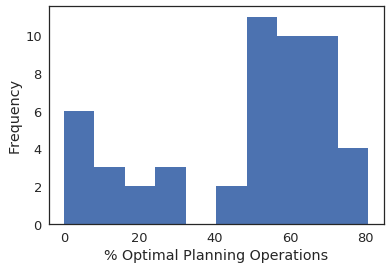

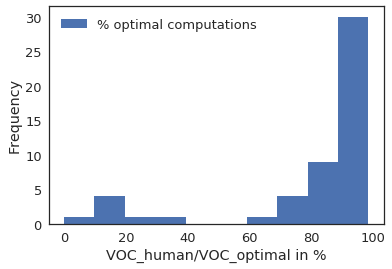

In [31]:
from agents import run_episode

import matplotlib.pyplot as plt


run_episode(bounded_optimal_agent, env)

stopped_too_early = np.array([])
continued_too_long = np.array([])
wrong_click = np.array([])
human_clicked = np.array([])

nr_nodes = 12
terminate = nr_nodes + 1 #node 0 is unclickable, nodes 1-12 are clickable, so action 13 is termination

suboptimal_computation = np.array([])
participant_id = np.array([])

Q_human = np.array([])
Q_optimal = np.array([])
Q_term = np.array([])

for t in trial_ids:

    trial_id = tdf['trial_id'][t]
    participant=tdf['pid'][t]
    ground_truth = tdf['env'][t].ground_truth
    env = tdf['env'][t]
    actions = np.append(tdf['clicks'][t],[terminate])    
        
    env.reset()
    c=0
    for action in actions:
        
        #What would a bounded-optimal agent do?
        action_distribution=bounded_optimal_agent.action_distribution(env._state)
        p_continue = np.sum(action_distribution[0:-1])
        p_terminate =action_distribution[terminate]
        p_human_click = action_distribution[int(action)]
        Q_human = np.append(Q_human,[Q_BO(env._state,action)])
        Q_optimal = np.append(Q_optimal,[V_BO(env._state)])
        Q_term = np.append(Q_term,[Q_BO(env._state,terminate)])
        
        human_clicked = np.append(human_clicked,[action!=terminate]) 
        
        suboptimal_computation = np.append(suboptimal_computation,[p_human_click == 0])
        participant_id = np.append(participant_id,[participant])
        
        if p_human_click == 0:
            stopped_too_early  = np.append(stopped_too_early, [action==terminate and p_continue>0.5])
            continued_too_long =  np.append(continued_too_long, [action!=terminate and p_terminate>0.5])
            wrong_click =  np.append(wrong_click, [action!=terminate and p_continue>0.5])
        
        
        step=env.step(action)

        
print("{:3.1f}% of people's computations are suboptimal.".format(100*np.mean(suboptimal_computation)))

avg_Q_ratio = np.mean(Q_human-Q_term)/np.mean(Q_optimal-Q_term)
print("On average, people's computations achieved {:3.1f}% of the highest possible VOC.".format(100*np.mean(avg_Q_ratio)))
        
print("{:3.1f}% of the time people deviate from optimal planning they terminate too early.".format(100*np.mean(stopped_too_early)))        
print("{:3.1f}% of the time people deviate from optimal planning they continue for too long.".format(100*np.mean(continued_too_long)))        
print("{:3.1f}% of the time people deviate from optimal planning they make the wrong click.".format(100*np.mean(wrong_click)))       

print("When people clicked there clicks were bounded-optimal about {:3.1f}% of the time.".format(100*np.mean(suboptimal_computation[human_clicked==1]==False)))

participants = np.unique(participant_id)

rationality_by_participant =np.array([])
Q_ratio =np.array([])
VOC_ratio =np.array([])

VOC_human = Q_human - Q_term
VOC_BO = Q_optimal - Q_term
#VOC_ratio = np.divide(VOC_human,VOC_BO+1e-9)

i=0
for p in participants:
    Q_ratio = np.append(Q_ratio,[100*np.mean(Q_human[participant_id ==p])/np.mean(Q_optimal[participant_id ==p])]) 
    VOC_ratio = np.append(VOC_ratio,[100*np.mean(VOC_human[participant_id ==p])/np.mean(VOC_BO[participant_id ==p])])
    rationality_by_participant = np.append(rationality_by_participant, [100-100*np.mean(suboptimal_computation[participant_id==p])])
    print("Participant {} was {:3.1f}% rational.".format(int(p),rationality_by_participant[-1]))
    print("The computations of participant {} achieved {:3.1f}% of the optimal VOC.".format(int(p),Q_ratio[-1]))
    i+=1

print("The most rational participant was {:3.1f}% rational.".format(np.max(rationality_by_participant)))
print("The least rational participant was {:3.1f}% rational.".format(np.min(rationality_by_participant)))
print("The average participant was {:3.1f}% rational (STD = {:3.1f}%).".format(np.mean(rationality_by_participant),np.std(rationality_by_participant)))

print("The most rational participant achieved {:3.1f}% of the optimal VOC.".format(np.max(VOC_ratio)))
print("The least rational participant achieved {:3.1f}% of the optimal VOC.".format(np.min(VOC_ratio)))
print("The average participant achieved {:3.1f}% of the optimal VOC (STD = {:3.1f}%).".format(np.mean(VOC_ratio),np.std(VOC_ratio)))


np.histogram(rationality_by_participant)
plt.hist(rationality_by_participant)
plt.xlabel('% Optimal Planning Operations')
plt.ylabel('Frequency')

plt.figure()
plt.hist(VOC_ratio)
plt.xlabel('VOC_human/VOC_optimal in %')
plt.ylabel('Frequency')

plt.legend(['% optimal computations','% optimal average VOC'])

In [318]:
VOC_ratio

array([ 0.934,  0.886,  0.969,  0.957,  0.952,  0.948,  0.094,  0.875,  0.501,  0.924,  0.9  ,  0.938,  0.961,  0.936,  0.953,  0.   ,  0.887,  0.921,  0.64 ,  0.88 ])

# R stats

In [15]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [8]:
rdf = df2r(tdf, ['trial_index', 'score'])

In [22]:
%%R -i rdf
m = lm(score ~ trial_index, data=rdf)
summary(m)


Call:
lm(formula = score ~ trial_index, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-117.073  -17.312    2.346   21.598   75.047 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  25.7907     2.5408  10.151   <2e-16 ***
trial_index  -0.1197     0.2286  -0.523    0.601    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 30.06 on 518 degrees of freedom
Multiple R-squared:  0.0005286,	Adjusted R-squared:  -0.001401 
F-statistic: 0.2739 on 1 and 518 DF,  p-value: 0.6009



In [29]:
joblib.dump(list(zip(tdf.trial_id, tdf.clicks)), 'data/empirical_clicks.pkl')

[autoreload of train_policies failed: Traceback (most recent call last):
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "bin/trai

['data/empirical_clicks.pkl']

In [41]:
def empirical_state_actions():
    for trial_id, clicks in zip(tdf.trial_id, tdf.clicks):
        if trial_id == 24987:
            continue # collision!
        env = make_env('constant_high', ground_truth=trials[trial_id])
        pol = FixedPlanPolicy([*clicks, env.term_action])
        trace = run_episode(pol, env)
        yield from zip(trace['states'], trace['actions'])

In [10]:
pol = lc_policy([-40, 1, 0, 0])

def yoked_returns(trial_id, clicks):
    env = make_env('constant_high', ground_truth=trials[trial_id])
    for click in clicks:
        yield sum(run_episode(pol, env)['rewards'])
        env.reset()
        env.init = env.step(click)[0]
 

In [12]:
from toolz import partition_all, concat
args = 
chunk_size = 10
chunks = partition_all(chunk_size, args)
def one(chunk):
    return sum(concat(yoked_returns(*args) for args in chunk))

one(next(chunks))

In [322]:
1+1








2